In [16]:
def give_me_df(ticker):
    import yfinance as yf
    import pandas as pd
    stock = yf.Ticker(ticker)
    df = stock.history(period='max')
    df[ticker] = df.Close.pct_change()
    return df[[ticker]].iloc[1:]

In [17]:
df1 = give_me_df('SPY') 
df2 = give_me_df('FB') 

In [18]:
def join_dfs(*dfs):
    import pandas as pd
    for idx, df_ in enumerate(dfs):
        if idx == 0:
            df = df_
        else:
            df = df.join(df_, how='inner')
    return df

In [19]:
df = join_dfs(df1, df2)

In [20]:
def train_test_split(df, test_size_ratio=0.3):
    import pandas as pd
    import numpy as np
    num_data = df.shape[0]
    num_data_train = int(num_data * (1-test_size_ratio)) 
    xy_train = df.iloc[:num_data_train].values
    xy_test = df.iloc[num_data_train:].values
    x_train = xy_train[:,:-1].astype(np.float32)
    y_train = xy_train[:,-1].astype(np.float32).reshape((-1,1))
    x_test = xy_test[:,:-1].astype(np.float32)
    y_test = xy_test[:,-1].astype(np.float32).reshape((-1,1))
    return x_train, y_train, x_test, y_test

In [21]:
x_train, y_train, x_test, y_test = train_test_split(df) 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(x_train.dtype, y_train.dtype, x_test.dtype, y_test.dtype)

(1478, 1) (1478, 1) (634, 1) (634, 1)
float32 float32 float32 float32


In [22]:
lr = 1e-3
epoch = int(1e5)

import tensorflow as tf
tf.reset_default_graph()

x = tf.placeholder(tf.float32, (None, 1), name='x')
y = tf.placeholder(tf.float32, (None, 1), name='y')

init_w = tf.keras.initializers.VarianceScaling(seed=0)
w = tf.get_variable('w', (1, 1), tf.float32, init_w)

init_b = tf.keras.initializers.zeros()
b = tf.get_variable('b', (), tf.float32, init_b)

y_pred = x @ w + b # (None, 1) @ (1, 1) = (None, 1)

diff = y - y_pred
loss = tf.nn.l2_loss(diff)

grads = tf.gradients(loss, [w, b])
loss_w = grads[0]
loss_b = grads[1]

train = [tf.assign(w, w - lr * loss_w), tf.assign(b, b - lr * loss_b)]

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    
    feed_dict = {x: x_train, y: y_train}
    loss_trace = []
    w_trace = []
    b_trace = []
    for i in range(epoch):
        _, loss_run, w_run, b_run = sess.run([train, loss, w, b],
                                             feed_dict=feed_dict)
        loss_trace.append(loss_run)
        w_trace.append(w_run[0,0])
        b_trace.append(b_run)
        if i%int(epoch/10)==0:
            print(f'{i+1}/{epoch} : {loss_run}')
        if i==(epoch-1):
            print(f'{i+1}/{epoch} : {loss_run}')
            
    w_trained, b_trained = sess.run([w, b]) 

1/100000 : 0.4573957026004791
10001/100000 : 0.36716318130493164
20001/100000 : 0.3530230224132538
30001/100000 : 0.35076528787612915
40001/100000 : 0.3504047989845276
50001/100000 : 0.3503471612930298
60001/100000 : 0.3503381311893463
70001/100000 : 0.350336492061615
80001/100000 : 0.35033634305000305
90001/100000 : 0.35033634305000305
100000/100000 : 0.35033634305000305


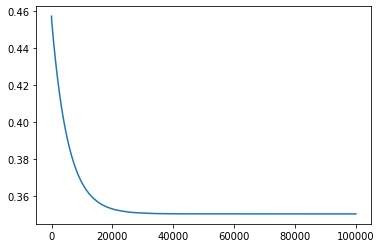

In [23]:
import matplotlib.pyplot as plt
plt.plot(loss_trace)
plt.show()

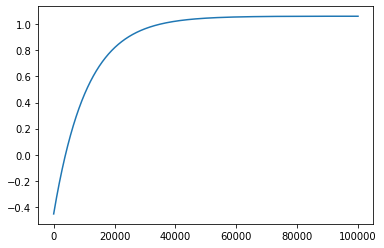

In [24]:
import matplotlib.pyplot as plt
plt.plot(w_trace)
plt.show()

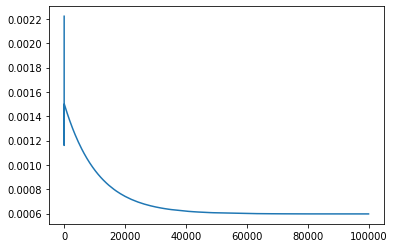

In [25]:
import matplotlib.pyplot as plt
plt.plot(b_trace)
plt.show()

In [26]:
with tf.Session() as sess:
    feed_dict = {x: x_train, w: w_trained, b: b_trained}
    y_train_pred = sess.run(y_pred, feed_dict=feed_dict)

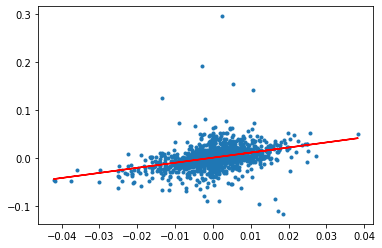

In [27]:
import matplotlib.pyplot as plt
plt.plot(x_train.reshape((-1,)), y_train.reshape((-1,)), '.')
plt.plot(x_train.reshape((-1,)), y_train_pred.reshape((-1,)), '-r')
plt.show()

In [28]:
with tf.Session() as sess:
    feed_dict = {x: x_test, w: w_trained, b: b_trained}
    y_test_pred = sess.run(y_pred, feed_dict=feed_dict)

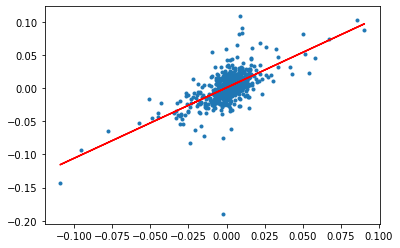

In [29]:
import matplotlib.pyplot as plt
plt.plot(x_test.reshape((-1,)), y_test.reshape((-1,)), '.')
plt.plot(x_test.reshape((-1,)), y_test_pred.reshape((-1,)), '-r')
plt.show()